# Lab 3: Clustering, Association Rules, or Recommenders

- Name 1: Jasmine Coleman
- Name 2: Yat Leung
- Name 3: Karen Somes

## Business Understanding  

__Purpose of Dataset:__ 

These data were collected to understand host/guest transactions on the AirBnb website to ensure that AirBnb is successful. AirBnb succeeds when the users succeed and consequentially continue to partake in business on the site. Ultimately, this means the key focus of the users, or hosts, is to make money. They do so by understanding market demand in their location, drivers of customer satisfaction, and important accomodation characteristics to make their listing the most attractive and profitable. The 60 variables in this dataset provide key information to understand the AirBnb market.

Furthermore, implementing cluster analysis on these data will allow hosts to gain a better understanding of their typical customer and competing listings in their market. For example, if a host wants to increase their listing price, they will understand the characteristics of accommodations they would need for listings in a higher price range. If they want better review scores, they can look at clusters with high review scores to view the features that are associated with high reviews. 

__Measuring Effectiveness:__ 

 -  How will you measure the effectiveness of a good algorithm?

__Value of Validation Measure:__ 

 - Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

### Data Understanding:

 - [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
 - [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.
 
 
 categorical on x axis and do a stacked bar of volume per cluster
 
 (tree based models are more greedy)gbm powerful with class imbalance, not logistic regression

__Data Cleaning:__  
First, we removed variables with high correlation, repetitive values, and attributes with a high number of missing values to narrow our focus of predictors and then we performed data transformations to aid our analysis.

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
data = pd.read_csv("/Users/ksomes/Downloads/listings.csv")

#data cleaning from LAB1
#drop redundant info and fields not useful for analysis
sub=data.drop(['id','listing_url','scrape_id','last_scraped','summary','space','description','experiences_offered'
              , 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
              'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url',
              'host_picture_url', 'country_code', 'country','amenities', 'minimum_minimum_nights',
              'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm',
              'maximum_nights_avg_ntm', 'availability_30', 'availability_365','availability_90','has_availability',
               'calculated_host_listings_count','calculated_host_listings_count_shared_rooms',
               'is_business_travel_ready','host_about', 'host_acceptance_rate', 'host_total_listings_count',
              'jurisdiction_names','license','monthly_price','square_feet','weekly_price', 'requires_license'], axis=1)
def money_to_decimal(x):
    x = x.replace("$", "").replace(",", "").replace(" ", "")
    return float(x)
def rem_percent(x):
    x=x.replace("%","")
    return float(x)/100
def truncate(n):
    return int(n * 1000) / 1000
#converts objects with money values into decimal values to become continous attribute
sub.cleaning_fee = sub.cleaning_fee.astype(str)
sub.extra_people = sub.extra_people.astype(str)
sub.security_deposit = sub.security_deposit.astype(str)
sub.price = sub.price.astype(str)
sub.loc[:,'price'] = sub.loc[:,'price'].apply(money_to_decimal)
sub.loc[:,'cleaning_fee'] = sub.loc[:,'cleaning_fee'].apply(money_to_decimal)
sub.loc[:,'extra_people'] = sub.loc[:,'extra_people'].apply(money_to_decimal)
sub.loc[:,'security_deposit'] = sub.loc[:,'security_deposit'].apply(money_to_decimal)

#imputations
sub['price']=sub.price.mask(sub.price == 0,sub.price.median())
sub.cleaning_fee=sub.cleaning_fee.fillna(sub.cleaning_fee.median())
sub.first_review=sub.first_review.fillna('2019-08-01')
sub['first_review'] =  pd.to_datetime(sub['first_review'],
                              format='%Y-%m-%d')
sub.host_response_rate = sub.host_response_rate.astype(str)
sub.loc[:,'host_response_rate'] = sub.loc[:, 'host_response_rate'].apply(rem_percent)
sub.host_response_rate=sub.host_response_rate.fillna(sub.host_response_rate.median())
sub['host_since'] =  pd.to_datetime(sub['host_since'],
                              format='%Y-%m-%d')
sub.last_review=sub.last_review.fillna('2019-08-01')
sub['last_review'] =  pd.to_datetime(sub['last_review'],
                              format='%Y-%m-%d')
sub.review_scores_accuracy=sub.review_scores_accuracy.fillna(truncate(sub.review_scores_accuracy.median()))
sub.review_scores_checkin=sub.review_scores_checkin.fillna(truncate(sub.review_scores_checkin.median()))
sub.review_scores_cleanliness=sub.review_scores_cleanliness.fillna(truncate(sub.review_scores_cleanliness.median()))
sub.review_scores_communication=sub.review_scores_communication.fillna(truncate(sub.review_scores_communication.median()))
sub.review_scores_location=sub.review_scores_location.fillna(truncate(sub.review_scores_location.median()))
sub.review_scores_rating=sub.review_scores_rating.fillna(truncate(sub.review_scores_rating.median())) ##
sub.review_scores_value=sub.review_scores_value.fillna(truncate(sub.review_scores_value.median()))
sub.reviews_per_month=sub.reviews_per_month.fillna(sub.reviews_per_month.median())
sub.security_deposit=sub.security_deposit.fillna(sub.security_deposit.median())
sub.bathrooms=sub.bathrooms.fillna(sub.bathrooms.median())
sub.bedrooms=sub.bedrooms.fillna(sub.bedrooms.median())
sub.host_listings_count=sub.host_listings_count.fillna(sub.host_listings_count.median())
sub.beds=sub.beds.fillna(sub.beds.median())
#sub.host_response_time=sub.host_response_time.fillna('missing')


/Users/ksomes/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Removed categorical variables

In [5]:

df_cont = sub.select_dtypes(include=['int', 'float']).columns #continuous columns
df=sub[df_cont]


    
#df = pd.concat([df_data],axis=1) #host_response,bed_type, neighborhood, room_type, cancel, prop_type

In [80]:
#df_data['property_type']#.map(prop_type_dict).fillna('OtherPropTypes')

__Final Dataset:__ 



In [6]:
df.shape

(48864, 17)

In [7]:
print(df.columns)

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


In [8]:
pd.set_option('display.max_columns', None)
df.head()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2,1.0,0.0,1.0,225.0,350.0,100.0,2,46,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0.39
1,2,1.0,1.0,1.0,150.0,200.0,75.0,2,0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0.71
2,3,1.0,1.0,4.0,89.0,500.0,50.0,1,274,90.0,10.0,9.0,10.0,9.0,10.0,9.0,4.64
3,1,1.0,1.0,1.0,80.0,100.0,80.0,1,9,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0.10
4,2,1.0,1.0,1.0,200.0,300.0,125.0,2,75,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0.60


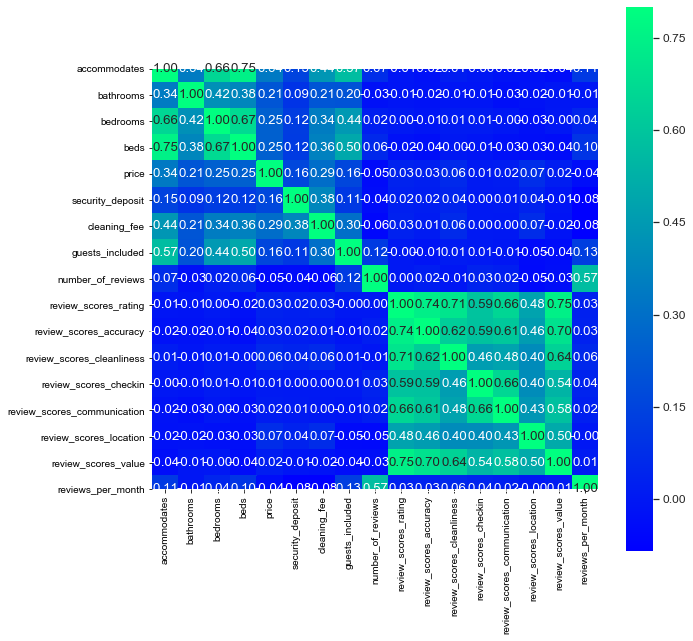

In [9]:
#dimensionality reduction only helps if features are correlated with each other
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = df_data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.1)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap = "winter")
plt.show()
#use heatmap to show which features are stronly correlated

This map shows that there are correlations amongst some of the features of similar categories (beds is related to accommodates and bathrooms and they all are related to the size of the accommodation, and review scores for different categories are correlated to other categories). However, this map also shows that there are not high correlationed between the accommodation attributes and the review attributes, meaning comparisons across categories have the potential to provide interesting insights.

### Important features

__Price:__  

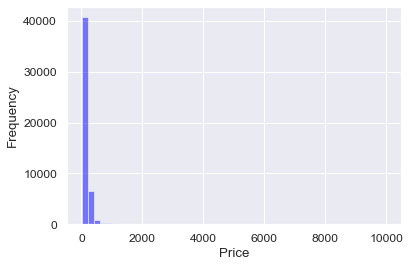

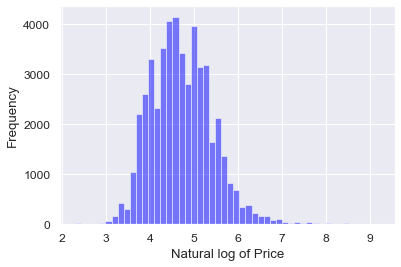

In [57]:
import math
num_bins=50
price=df_data.iloc[:,4].values
n, bins, patches = plt.hist(df_data.price, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
n, bins, patches = plt.hist(np.log(price), num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Natural log of Price')
plt.ylabel('Frequency')
plt.show()
#print(price)

The prices are significantly skewed right by listings that dwarf the other prices. A majority of the listings are cheaper than a few expensive ones. A natural log transformation shown above is an effective way to normalize the spread.

__Security_deposit:__  

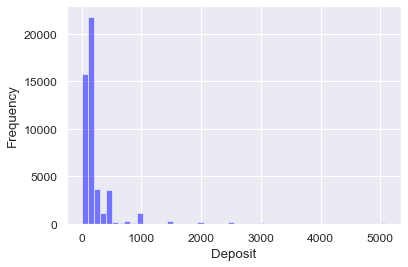

count    48864.000000
mean       221.304969
std        419.419799
min          0.000000
25%        100.000000
50%        120.000000
75%        200.000000
max       5100.000000
Name: security_deposit, dtype: float64

In [71]:
n, bins, patches = plt.hist(df_data.security_deposit, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Deposit')
plt.ylabel('Frequency')
plt.show()
df_data.security_deposit.describe()

Like price, there is a large right skew since one of the listings has a securty deposit that is 25 times as large as the lower 75% of the data. Half of the listings have a security deposit of 120 dollars or less. 

__Beds:__

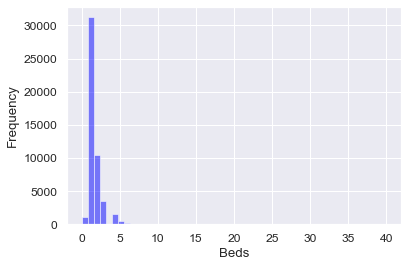

count    48864.000000
mean         1.547602
std          1.111982
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         40.000000
Name: beds, dtype: float64

In [64]:
num_bins=50
beds=df_data.iloc[:,3].values
n, bins, patches = plt.hist(df_data.beds, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.show()
df_data.beds.describe()

The beds variable is also skewed right by a listing with 40 beds. 75% of the listings only have 1 or 2 beds.

__Number of reviews:__  

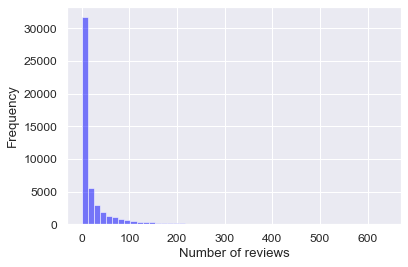

count    48864.000000
mean        23.392191
std         44.939690
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        639.000000
Name: number_of_reviews, dtype: float64

In [69]:
num_bins=50
num_rev=df_data.iloc[:,8].values
n, bins, patches = plt.hist(df_data.number_of_reviews, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Number of reviews')
plt.ylabel('Frequency')
plt.show()
df_data.number_of_reviews.describe()

75% of the listings have 24 reviews or less. Some listings, due to either age, popularity, or short term listings, have many more reviews. The most reviews a listing has is 639.

## Modeling and Evaluation

### Option A: Cluster Analysis

 - Perform cluster analysis using several clustering methods
 - How did you determine a suitable number of clusters for each method?
 - Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
 - Describe your results. What findings are the most interesting and why? 


In [10]:
#skip
#https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

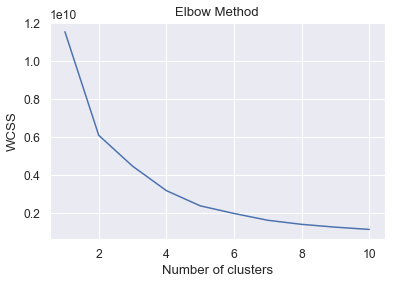

In [93]:
#https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

#finding best number of clusters
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

wcss = []
#within cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
#kmeans.fit(sub_cont)
pred_y = kmeans.fit_predict(df_data)

In [21]:
centroids = kmeans.cluster_centers_
labels=kmeans.labels_
print(centroids.shape)
print(kmeans.labels_.shape)
print(df_data.shape)
print(df_data.columns)

(6, 17)
(48864,)
(48864, 17)
Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


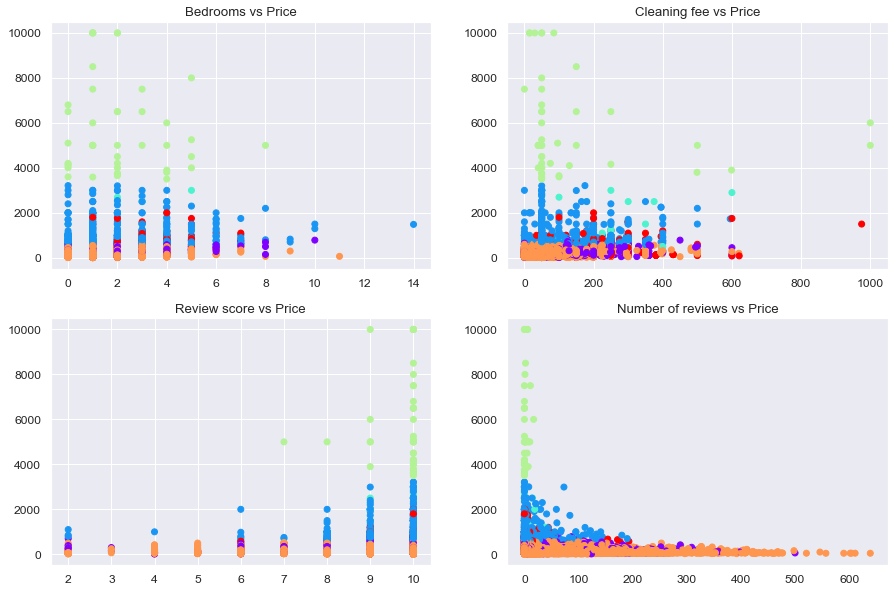

In [26]:
# visualize the data
centroids = kmeans.cluster_centers_
labels=kmeans.labels_
#colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']

fig, axs = plt.subplots(2, 2,figsize=(15,10))
axs[0, 0].scatter(df.iloc[:, 2], df.iloc[:, 4], c=kmeans.labels_, cmap='rainbow')
axs[0, 0].set_title('Bedrooms vs Price')
axs[0, 1].scatter(df.iloc[:, 6], df.iloc[:, 4], c=kmeans.labels_, cmap='rainbow')
axs[0, 1].set_title('Cleaning fee vs Price')
axs[1, 0].scatter(df.iloc[:, 15], df.iloc[:, 4], c=kmeans.labels_, cmap='rainbow')
axs[1, 0].set_title('Review score vs Price')
axs[1, 1].scatter(df.iloc[:, 8], df.iloc[:, 4], c=kmeans.labels_, cmap='rainbow')
axs[1, 1].set_title('Number of reviews vs Price')

#plt.scatter(df.iloc[:, 2], df.iloc[:, 4], c=kmeans.labels_, cmap='rainbow') #plot the data
#plt.title('K-means clustering for continuous features')
#plt.xlabel('sub, Bedrooms')
#plt.ylabel('sub, Price')
plt.grid()
plt.show()

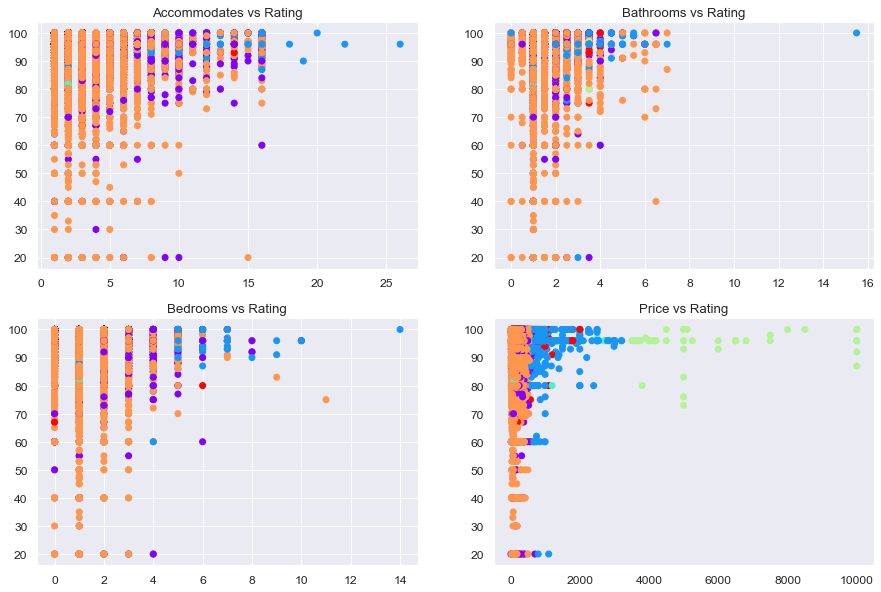

In [28]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
axs[0, 0].scatter(df.iloc[:, 0], df.iloc[:, 9], c=kmeans.labels_, cmap='rainbow')
axs[0, 0].set_title('Accommodates vs Rating')
axs[0, 1].scatter(df.iloc[:, 1], df.iloc[:, 9], c=kmeans.labels_, cmap='rainbow')
axs[0, 1].set_title('Bathrooms vs Rating')
axs[1, 0].scatter(df.iloc[:, 2], df.iloc[:, 9], c=kmeans.labels_, cmap='rainbow')
axs[1, 0].set_title('Bedrooms vs Rating')
axs[1, 1].scatter(df.iloc[:, 4], df.iloc[:, 9], c=kmeans.labels_, cmap='rainbow')
axs[1, 1].set_title('Price vs Rating')

plt.grid()
plt.show()

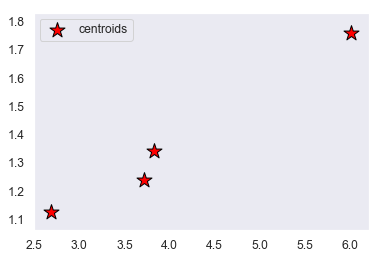

In [102]:
# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [104]:
#getting # of clusters
import numpy as np

np.unique(labels)

array([0, 1, 2, 3])

In [105]:
#creating new cluster_group column in data frame for the labels
import numpy as np

df_data['cluster_group'] = np.nan
data_length = len(df_data)
for i in range(data_length):
    df_data.iloc[i, df_data.columns.get_loc('cluster_group')] = labels[i]

In [106]:
df_data.head()


,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,cluster_group
0,2,1.0,0.0,1.0,225.0,350.0,100.0,2,46,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0.39,0.0
1,2,1.0,1.0,1.0,150.0,200.0,75.0,2,0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0.71,0.0
2,3,1.0,1.0,4.0,89.0,500.0,50.0,1,274,90.0,10.0,9.0,10.0,9.0,10.0,9.0,4.64,3.0
3,1,1.0,1.0,1.0,80.0,100.0,80.0,1,9,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0.10,0.0
4,2,1.0,1.0,1.0,200.0,300.0,125.0,2,75,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0.60,0.0


In [107]:
airbnb_cluster_data = df_data.groupby(['cluster_group']).mean()
airbnb_cluster_data

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
cluster_group,,,,,,,,,,,,,,,,,
0.0,2.685768,1.124894,1.126812,1.473048,129.750910,106.981598,54.282999,1.429250,24.106915,94.299713,9.701589,9.423920,9.805899,9.809613,9.654704,9.541398,1.279873
1.0,3.831750,1.339891,1.583446,2.054274,305.704206,2859.491180,155.757123,1.804613,9.755767,95.458616,9.804613,9.658073,9.831750,9.845319,9.812754,9.540027,0.680597
2.0,6.017857,1.758929,1.964286,2.750000,5172.267857,601.107143,127.303571,1.339286,3.017857,94.946429,9.857143,9.767857,9.714286,9.803571,9.821429,9.803571,0.693393
3.0,3.716102,1.236985,1.412984,1.948699,228.033444,641.186592,103.083384,2.033444,20.601090,94.912379,9.727603,9.532536,9.805841,9.819461,9.721398,9.500000,0.981026


In [108]:
#adding counts
airbnb_cluster_data['Counts'] = pd.Series(df_data.groupby(['cluster_group']).size())
airbnb_cluster_data

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,Counts
cluster_group,,,,,,,,,,,,,,,,,,
0.0,2.685768,1.124894,1.126812,1.473048,129.750910,106.981598,54.282999,1.429250,24.106915,94.299713,9.701589,9.423920,9.805899,9.809613,9.654704,9.541398,1.279873,41463
1.0,3.831750,1.339891,1.583446,2.054274,305.704206,2859.491180,155.757123,1.804613,9.755767,95.458616,9.804613,9.658073,9.831750,9.845319,9.812754,9.540027,0.680597,737
2.0,6.017857,1.758929,1.964286,2.750000,5172.267857,601.107143,127.303571,1.339286,3.017857,94.946429,9.857143,9.767857,9.714286,9.803571,9.821429,9.803571,0.693393,56
3.0,3.716102,1.236985,1.412984,1.948699,228.033444,641.186592,103.083384,2.033444,20.601090,94.912379,9.727603,9.532536,9.805841,9.819461,9.721398,9.500000,0.981026,6608


Looking at feature means for each cluster.

In [100]:
pd.set_option('display.max_columns', None)
df_data[ df_data['cluster_group'] == 0 ].describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,cluster_group
count,9080.00000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.000000,9080.0
mean,2.81630,1.141905,1.159361,1.556167,141.882599,188.355947,60.012555,1.494493,22.917070,94.112004,9.677753,9.434912,9.790749,9.779185,9.632379,9.519273,1.454735,0.0
std,1.94306,0.427778,0.748932,1.170711,205.188195,403.144103,51.508728,1.172515,37.635662,8.077163,0.820295,1.020850,0.697139,0.714912,0.735762,0.877735,1.661831,0.0
min,1.00000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.030000,0.0
25%,2.00000,1.000000,1.000000,1.000000,60.000000,0.000000,30.000000,1.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.400000,0.0
50%,2.00000,1.000000,1.000000,1.000000,99.000000,120.000000,50.000000,1.000000,6.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.710000,0.0
75%,4.00000,1.000000,1.000000,2.000000,165.000000,125.000000,75.000000,2.000000,29.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.010000,0.0
max,16.00000,6.500000,11.000000,26.000000,10000.000000,5000.000000,620.000000,16.000000,443.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,19.190000,0.0


In [64]:
pd.set_option('display.max_columns', None)
df_data[ df_data['cluster_group'] == 2 ].describe()

,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month,cluster_group
count,7.541000e+03,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.00000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.0
mean,2.292133e+08,40.729645,-73.943825,3.180878,1.203554,1.255404,1.76157,161.352738,198.742342,64.789418,1.683464,14.830129,6.939663,642.178491,10.439464,9.608673,9.468240,9.727622,9.706935,9.682668,9.478849,16.820713,2.721257,1.937207,2.0
std,3.058086e+07,0.058192,0.058753,2.253358,0.524220,0.854858,1.30878,227.644119,411.082141,57.427809,1.379820,21.764289,19.174169,544.994260,16.946333,0.987870,1.091421,0.822313,0.910470,0.779004,1.009890,69.775333,5.781179,2.066478,0.0
min,1.718887e+08,40.506410,-74.230590,1.000000,0.000000,0.000000,0.00000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.060000,2.0
25%,2.043464e+08,40.691450,-73.986110,2.000000,1.000000,1.000000,1.00000,62.000000,0.000000,25.000000,1.000000,0.000000,1.000000,29.000000,0.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.000000,0.000000,0.710000,2.0
50%,2.265039e+08,40.730320,-73.952690,2.000000,1.000000,1.000000,1.00000,100.000000,120.000000,50.000000,1.000000,5.000000,2.000000,1125.000000,3.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,2.0
75%,2.578673e+08,40.762720,-73.921230,4.000000,1.000000,1.000000,2.00000,199.000000,200.000000,95.000000,2.000000,25.000000,4.000000,1125.000000,13.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,3.000000,2.740000,2.0
max,2.830244e+08,40.912400,-73.721730,22.000000,7.000000,10.000000,17.00000,7500.000000,5000.000000,1000.000000,16.000000,300.000000,999.000000,9999.000000,242.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,335.000000,46.000000,66.610000,2.0


In [65]:
pd.set_option('display.max_columns', None)
df_data[ df_data['cluster_group'] == 3 ].describe()

,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month,cluster_group
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
pd.set_option('display.max_columns', None)
df_data[ df_data['cluster_group'] == 1 ].describe()

,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month,cluster_group
count,3.224300e+04,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,3.224300e+04,32243.000000,32243.00000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.000000,32243.0
mean,1.936960e+07,40.728123,-73.956292,2.776355,1.130695,1.158112,1.495146,151.865614,235.860745,62.659864,1.483671,14.355302,7.190677,6.851568e+04,26.555376,9.73799,9.438669,9.828893,9.845021,9.672022,9.554198,2.689452,0.939770,1.000929,1.0
std,1.792141e+07,0.052397,0.038867,1.756873,0.407072,0.716063,1.036311,246.571177,425.060449,47.700340,1.068147,24.977002,21.465530,1.196050e+07,50.451554,0.67519,0.970974,0.569771,0.548344,0.659201,0.783769,12.682352,2.497657,1.260895,0.0
min,2.438000e+03,40.499790,-74.244420,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.010000,1.0
25%,4.129805e+06,40.689800,-73.983030,2.000000,1.000000,1.000000,1.000000,70.000000,100.000000,35.000000,1.000000,0.000000,2.000000,2.900000e+01,1.000000,10.00000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,0.000000,0.190000,1.0
50%,1.348137e+07,40.721280,-73.957290,2.000000,1.000000,1.000000,1.000000,110.000000,120.000000,50.000000,1.000000,0.000000,3.000000,1.124000e+03,6.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.710000,1.0
75%,3.081249e+07,40.762290,-73.940605,4.000000,1.000000,1.000000,2.000000,175.000000,250.000000,80.000000,2.000000,25.000000,5.000000,1.125000e+03,26.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.120000,1.0
max,6.696177e+07,40.908040,-73.712990,26.000000,15.500000,14.000000,40.000000,10000.000000,5100.000000,1000.000000,16.000000,300.000000,1250.000000,2.147484e+09,639.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,119.000000,43.000000,16.080000,1.0


In [ ]:
pd.set_option('display.max_columns', None)
df_data[ df_data['cluster_group'] == 4 ].describe()

MeanShift clustering (takes a long time to run)

In [ ]:
# Getting the size of the bandwidth which MeanShift will have used by default
from sklearn.cluster import estimate_bandwidth

est_band = estimate_bandwidth(df_data)
#30 would be a good bandwidth for this data

In [ ]:
est_band

In [ ]:
from sklearn.cluster import MeanShift

analyzer = MeanShift(bandwidth=est_band)
#bandwidth is the only hyperparameter passed into model
analyzer.fit(df_data)
#call fit to start training on the data

In [ ]:
#getting labels generated by MeanShift of AirBnB data
labels = analyzer.labels_

In [ ]:
#getting # of clusters
import numpy as np

np.unique(labels)
#bandwidth of 30 produced 5 clusters

In [ ]:
#creating new cluster_group column in data frame for the labels
import numpy as np

df_data['cluster_group'] = np.nan
data_length = len(df_data)
for i in range(data_length):
    df_data.iloc[i, df_data.columns.get_loc('cluster_group')] = labels[i]

__Assessing Cluster Analysis__  


### Deployment: 

 - This model can help hosts understand what factors contribute most to a high review score (especially since the model is more accurate at predicting high scores), allowing hosts to become more hospitable
 - The model value can be measured by tracking trends of the host's review score over time to see if they have made improvements
 - This model would be best deployed on the host's view of their profile so they can manage their accomodations to be competitive to others in the market
 - The model would not have to be updated frequently because it predicts an aggregate score; a quarterly refresh is reasonable
 - Other beneficial data to collect is whether guests are repeat visitor's or not; this would most likely skew results positively
 
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.? 